In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib

import numpy as np

from scipy.ndimage import rotate, shift
from astropy.io import ascii, fits
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord, concatenate
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
from astropy import constants as const
from astropy.modeling import models, fitting
from astropy.nddata import Cutout2D

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

ImportError: cannot import name 'NUMPY_LT_2_0' from 'astropy.utils.compat.numpycompat' (/home/raquel/anaconda3/lib/python3.9/site-packages/astropy/utils/compat/numpycompat.py)

# Useful functions

In [2]:
plot_chan_cube_default_params = {
    'font_size': 10,
    'use_tex': False,
    'vrel': False,
    'systemic_velocity': None,
    'vel_decimals': 2,
    'wcs': None,
    'ax': None,
    'fig_size': 7,
    'rotate_ticktext_yaxis': False,
    'norm': None,
    'contour_sigma_filter': None,
    'offset_coordinates': None,
    'offset_center': None,
    'render': "raster",
    'tick_direction': "in",
    'grid_color': "k",
    'label_color': "k",
    'grid_linewidth': 10,
    'tick_width': 1,
    'tick_length': 8,
    'minortick_length': 4,
    'tick_x_pad': 1,  
    'tick_y_pad': 1,  
    'display_x_minor_ticks': True,
    'display_y_minor_ticks': True,   
    'textbox': None,
    'overplot_contours': False,
    'origin': 'lower',
    'cube_aspect': 'equal',
    'cmap': 'viridis',
    'interpolation': None,
    'filterrad': 4,
    'alpha_imshow': None,
    'contour_levels': None,
    'contour_linewidths': 1,
    'contour_colors': 'k',
    'contour_zorder': 2,
    'contour_alpha': 1,
    'tick_x_spacing': 1,
    'tick_y_spacing': 1.5,
    'plot_vel': True,
    'boxstyle': 'round',
    'box_facecolor': 'white',
    'alpha_box': 0.85,
    'x_box': 0.65,
    'y_box': 0.95,
    'box_fontsize': 10, 
    'textcolor': 'k',
    'plot_cbar': False,
    'colorbar_shrink': 1,
    'colorbar_aspect':20,
    'colorbar_ngrid':0,
    'colorbar_orientation':'vertical',
    'colorbar_fraction':0.15,
    'colorbar_pad':0.05,
    'colorbar_anchor':(0.0,0.5),
    'colorbar_panchor':(1.0,0.5),
    'colorbar_show':True,
    'colorbar_labelpad':10,
    'colorbar_ticks':None,
    'colorbar_format':'%.2f',
    'colorbar_nticks':None,
    'colorbar_invertticklabels': False,
    'colorbar_label_SMA_dist': 'Deprojected Velocity (km/s)',
    'colorbar_negative_ticklabels': True,
    'colorbar_outlinelinewidth': 0.5,
    'colorbar_units': 'Jy/beam',
    'colorbar_strformat': None,    
    'cbar_label_pad':20,
    'cbar_unit': None,
    'cbarvmin': None,
    'cbarvmax': None,
    'label_cbar': "",
    'cbar_pad':0.05,
    'cbar_fraction':0.1,
    'cbar_extend':'both',
    'cbar_shrink':1,
    'cbar_anchor':(0.0, 0.5),
    'cbar_panchor':(1.0, 0.5),
    'cbar_aspect':20,
    'cbar_setticks': None,
    'cbax': None,
    'cbar_end': None,
    'add_beam':True,
    'beam_linewidth':1,
    'beam_color':'k',
    'beam_fill': False,
    'beam_factor_rectangle': 1.5,
    'add_beam_rectangle': False,
    'beam_color_rectangle':'w',
    'beam_edgecolor_rectangle':'k',
    'beam_fill_rectangle': False,
    'beam_nax':0,
    'xpos_beam':7,
    'ypos_beam':7,
    'add_scalebar':False,
    'scalebar_distance':100,
    'scalebar_fontsize':15,
    'scalebar_width':1.,
    'scalebar_color':'white',
    'scalebar_loc':'lower right',
    'scalebar_pad':1,
    'scalebar_units':'au',
    'scalebar_nax':0,
    'scalebar_labeltop':False,
    'scalebar_sep':5.,
    'scalebar_bbox_to_anchor': None,
    'add_scalebar_rectangle': False,
    "scalebar_coords_rectangle": (0,0),
    "scalebar_width_rectangle": 1,
    "scalebar_height_rectangle": 1,
    'scalebar_color_rectangle': "k",
    'scalebar_edgecolor_rectangle': "k",
    'scalebar_color_rectangle': "k",
    'scalebar_fill_rectangle': True,
    'source_distance_pc':None, #pc
    'output_name': None,
    'show_plot': True,
    'return_ax': False,
    'return_im': False,
    'icrs_xlabel':'ICRS RA',
    'icrs_ylabel':'ICRS DEC',
    'xlabelpad': 1,
    'ylabelpad': -0.5,
}
    
def vel_from_header(header, velaxis=3):
    """
    Returns a list of the velocities corresponding to de velocity channels
    """
    rest_freq = header['RESTFRQ'] * u.Hz
    hz_per_chan = header[f'CDELT{velaxis}'] * u.Hz
    chanref_freq = header[f'CRVAL{velaxis}'] * u.Hz
    vel_per_chan = (const.c / rest_freq * hz_per_chan).to(u.km/u.s)
    vref = (const.c / rest_freq * (rest_freq-chanref_freq)).to(u.km/u.s)
    vf = (vref - vel_per_chan *
          (header[f'NAXIS{velaxis}']-header[f"CRPIX{velaxis}"])).to(u.km/u.s)
    v0 = vref + (header[f"CRPIX{velaxis}"]-1) * vel_per_chan
    v_channels = np.linspace(
        v0.value,
        vf.value,
        int(header[f'NAXIS{velaxis}']))
    return v_channels
    
    
def plot_chan_cube(cube, channel, hdr, box=None, **kwargs):
    
    """
    Makes a plot for a given spectral slice of the cube
    box = [[x_1,y_1],[x_2,y_2]]
    """
    for param in plot_chan_cube_default_params:
        kwargs[param] = kwargs[param] \
                if param in kwargs \
                else plot_chan_cube_default_params[param]

    # changes the size of labels
    matplotlib.rcParams.update({'font.size': kwargs['font_size']})
    # set False to unable latex rendering
    plt.rc('text', usetex=kwargs['use_tex'])

    v_channels = vel_from_header(hdr)
    offsets = [-hdr['CRPIX1']*hdr['CDELT1'],
               hdr['CRPIX1']*hdr['CDELT1']]
#    extent = [offsets[0], offsets[1], v_channels[0], v_channels[-1]]
    extent = None
    image = cube[channel]
    if kwargs['vrel']:
        vch = v_channels[channel] - kwargs['systemic_velocity']
    else:
        vch = v_channels[channel]
    vel_str = f"{vch:.{kwargs['vel_decimals']}f} km/s"

    wcs = kwargs["wcs"] if kwargs["wcs"] is not None else WCS(hdrs[ck]).celestial
    cbax = kwargs["cbax"]
    
    if kwargs["ax"] is None:
        fig = plt.figure(figsize=(kwargs['fig_size'], kwargs['fig_size']))
        ax = plt.subplot(projection=wcs)
    else:
        fig = plt.gcf()
        ax = kwargs["ax"]
    
    if kwargs['rotate_ticktext_yaxis'] is not None:
        ax.coords[1].set_ticklabel(rotation=kwargs['rotate_ticktext_yaxis'])

    if kwargs['norm'] == 'linear':
        norm = colors.Normalize(vmax=kwargs['vmax'], vmin=kwargs['vmin'])
    elif kwargs['norm'] is None:
        norm = None
    elif kwargs['norm'] == 'log':
        norm = colors.LogNorm(vmin=kwargs['vmin'], vmax=kwargs['vmax'])
    elif kwargs['norm'] == 'symlog':
        norm = colors.SymLogNorm(colors.SymLogNorm(
            linthresh=kwargs['linthresh'],
            linscale=kwargs['linscale'],
            vmin=kwargs['vmin'],
            vmax=kwargs['vmax']))
    elif kwargs['norm'] == 'divnorm':
        norm = mcolors.TwoSlopeNorm(vcenter=kwargs['vcenter'],
                                   vmin=kwargs['vmin'],
                                   vmax=kwargs['vmax'])
    else:
        norm = None

    if kwargs['contour_sigma_filter'] is not None:
        image = gaussian_filter(image,
                                sigma=kwargs['contour_sigma_filter'])
    else:
        pass

    if kwargs['offset_coordinates'] is not None:
        if kwargs["ax"] is None:
            fig, ax = plt.subplots(figsize=(kwargs['fig_size'],
                                            kwargs['fig_size']))

        center_skycoords = SkyCoord(kwargs["offset_center"],
                                    kwargs["offset_center"])

        center_pixels = [
            float(skycoord_to_pixel(center_skycoords, wcs)[0]),
            float(skycoord_to_pixel(center_skycoords, wcs)[1])
        ]

        x0y0_extent = mf.pixel2offset([0,0],
                             [hdr["CDELT1"]*3600,
                              hdr["CDELT2"]*3600],
                             center_pixels,
                             bounds=True)

        xNyN_extent = mf.pixel2offset([hdr["NAXIS1"]-1,
                                       hdr["NAXIS2"]-1],
                             [hdr["CDELT1"]*3600,
                              hdr["CDELT2"]*3600],
                             center_pixels,
                             bounds=True)

        extent = [x0y0_extent[0], xNyN_extent[0],
                  x0y0_extent[1], xNyN_extent[1]]

        x0y0lim = mf.pixel2offset(box[0],
                             [hdr["CDELT1"]*3600,
                              hdr["CDELT2"]*3600],
                             center_pixels,
                             bounds=True)

        xNyNlim = mf.pixel2offset(box[1],
                             [hdr["CDELT1"]*3600,
                              hdr["CDELT2"]*3600],
                             center_pixels,
                             bounds=True)

        ax_transform = ax.transData

    else:
        pass
    if kwargs['render'] == 'raster':
        im = ax.imshow(image,
                       origin=kwargs['origin'],
                       aspect=kwargs['cube_aspect'],
                       cmap=kwargs['cmap'],
                       norm=norm,
                       extent=extent,
                       interpolation=kwargs['interpolation'],
                       filterrad=kwargs['filterrad'],
                       # transform=ax_transform,
                       alpha=kwargs["alpha_imshow"])
    #                    vmin=kwargs['vmin'], vmax=kwargs['vmax'])
    elif kwargs['render'] == 'contours':
        im = ax.contour(image,
                        levels=kwargs['contour_levels'],
                        linewidths=kwargs['contour_linewidths'],
                        origin=kwargs['origin'],
                        linestyles=kwargs['contour_styles'],
                        extent=extent,
                        colors=kwargs['contour_colors'],
                        norm=norm,
                        transform=ax_transform,
                        zorder=kwargs['contour_zorder'])
    elif kwargs['render'] == 'contourfs':
        im = ax.contourf(image,
                         levels=kwargs['contour_levels'],
                         linewidths=kwargs['contour_linewidths'],
                         origin=kwargs['origin'],
                         extent=extent,
                         cmap=kwargs['cmap'],
                         norm=norm,
                         transform=ax_transform,
                         zorder=kwargs['contour_zorder'],)

        if kwargs['overplot_contours']:
            im = ax.contour(image,
                            levels=kwargs['contour_levels'],
                            linewidths=kwargs['contour_linewidths'],
    #                        linewidths=kwargs['contour_linewidths'],
                            origin=kwargs['origin'],
                            extent=extent,
                            colors=kwargs['contour_colors'],
    #                        colors=kwargs['contour_colors'],
                            norm=norm,
                            transform=ax_transform,
                            zorder=kwargs['contour_zorder'],
                            alpha=kwargs['contour_alpha'])

    else:
        im = ax.imshow(image,
                       origin=kwargs['origin'],
                       aspect=kwargs['cube_aspect'],
                       cmap=kwargs['cmap'],
                       norm=norm,
                       extent=extent,
                       interpolation=kwargs['interpolation'],
                       filterrad=kwargs['filterrad'],
                       alpha=kwargs["alpha_imshow"])
        ax.contour(image,
                   levels=kwargs['contour_levels'],
                   linewidths=kwargs['contour_linewidths'],
                   origin=kwargs['origin'],
                   extent=extent,
                   colors=kwargs['contour_colors'],
                   norm=norm,)
    if kwargs["offset_coordinates"]:
        xaxis = ax.get_xaxis()
        yaxis = ax.get_yaxis()
    else:
        xaxis = ax.coords[0]
        yaxis = ax.coords[1]
        xaxis.tick_params(direction=kwargs['tick_direction'],
                          grid_color=kwargs['grid_color'],
                          colors=kwargs['grid_color'],
                          labelcolor=kwargs['label_color'],
                          color=kwargs['grid_color'],
                          grid_linewidth=kwargs['grid_linewidth'],
                          width=kwargs['tick_width'],
                          length=kwargs['tick_length'],
                          pad=kwargs['tick_x_pad'])

        yaxis.tick_params(direction=kwargs['tick_direction'],
                          grid_color=kwargs['grid_color'],
                          colors=kwargs['grid_color'],
                          labelcolor=kwargs['label_color'],
                          color=kwargs['grid_color'],
                          grid_linewidth=kwargs['grid_linewidth'],
                          width=kwargs['tick_width'],
                          length=kwargs['tick_length'],
                          pad=kwargs['tick_y_pad'])

        xaxis.display_minor_ticks(kwargs['display_x_minor_ticks'])
        yaxis.display_minor_ticks(kwargs['display_y_minor_ticks'])

        yaxis.set_ticks_position('all')
        xaxis.set_ticks_position('all')

        xaxis.tick_params(which='minor', length=kwargs['minortick_length'])
        yaxis.tick_params(which='minor', length=kwargs['minortick_length'])

        # xaxis.set_ticks(spacing=kwargs['tick_x_spacing'] * u.arcsec)
        # yaxis.set_ticks(spacing=kwargs['tick_y_spacing'] * u.arcsec)

        xaxis.set_ticklabel(exclude_overlapping=True)
        ax.tick_params(labelsize=kwargs['font_size'])

    if kwargs['plot_vel'] and vel_str!=None:
        props = dict(
            boxstyle=kwargs['boxstyle'],
            facecolor=kwargs['box_facecolor'],
            alpha=kwargs['alpha_box']) if kwargs['textbox'] else None

        ax.text(kwargs['x_box'],
                kwargs['y_box'],
                vel_str,
                fontsize=kwargs['box_fontsize'],
                color=kwargs['textcolor'],
                verticalalignment='top',
                transform=ax.transAxes,
                bbox=props)
    elif kwargs['plot_vel'] and vel_str==None:
        props = dict(
            boxstyle=kwargs['boxstyle'],
            facecolor=kwargs['box_facecolor'],
            alpha=kwargs['alpha_box']) if kwargs['textbox'] else None

        vel_str = kwargs['plot_vel']

        ax.text(kwargs['x_box'],
                kwargs['y_box'],
                vel_str,
                fontsize=kwargs['box_fontsize'],
                color=kwargs['textcolor'],
                verticalalignment='top',
                transform=ax.transAxes,
                bbox=props)
    else:
        pass



    if kwargs['plot_cbar'] and (cbax is None):
        cbar_unit = kwargs["cbar_unit"] if kwargs["cbar_unit"] is not None else hdr["BUNIT"]
        cbar = plt.colorbar(im,
                            ax=ax,
                            orientation=kwargs['colorbar_orientation'],
                            fraction=kwargs['colorbar_fraction'],
                            pad=kwargs['colorbar_pad'],
                            shrink=kwargs['colorbar_shrink'],
                            aspect=kwargs['colorbar_aspect'],
                            anchor=kwargs['colorbar_anchor'],
                            panchor=kwargs['colorbar_panchor'],
                            extend=kwargs['cbar_extend'])
        if kwargs['colorbar_orientation'] == 'vertical':
            cbar.ax.set_ylabel(cbar_unit)
        elif kwargs['colorbar_orientation'] == 'horizontal':
            cbar.ax.set_xlabel(cbar_unit)

    elif kwargs['plot_cbar'] and (cbax is not None):
        cbar = plt.colorbar(
            im,
            ax=ax,
            # cmap=kwargs['cmap_ellipses'],
            cax=cbax,
            # orientation='horizontal',
            orientation=kwargs['colorbar_orientation'],
            fraction=kwargs['colorbar_fraction'],
            pad=kwargs['colorbar_pad'],
            shrink=kwargs['colorbar_shrink'],
            aspect=kwargs['colorbar_aspect'],
            anchor=kwargs['colorbar_anchor'],
            panchor=kwargs['colorbar_panchor'],
            extend=kwargs['cbar_extend'],
            format=kwargs['colorbar_format'])
        if kwargs['colorbar_units'] == 'mJy/beam':
            if kwargs['colorbar_orientation'] == "vertical":
                cbar_ticklabels = ['{:.0f}'.format(i*1000) for i in cbar.ax.get_yticks()]
                cbar.ax.set_yticklabels(cbar_ticklabels)
                cbar.ax.set_ylabel(kwargs['colorbar_units'],
                                   fontsize=kwargs['font_size'],
                                   labelpad=kwargs['colorbar_labelpad']
                 )
            elif kwargs['colorbar_orientation'] == "horizontal":
                cbar_ticklabels = ['{:.0f}'.format(i*1000) for i in cbar.ax.get_xticks()]
                cbar.ax.set_xticklabels(cbar_ticklabels)
                cbar.ax.set_xlabel(kwargs['colorbar_units'],
                                   fontsize=kwargs['font_size'],
                                   labelpad=kwargs['colorbar_labelpad']
                                  )
        else:
            pass


        if kwargs['colorbar_orientation'] == 'horizontal':
            if kwargs['colorbar_negative_ticklabels']:
                cbar_ticklabels = ['-{}'.format(i.get_text())
                                   for i in cbax.get_xticklabels()]
                cbar.ax.set_xticklabels(cbar_ticklabels,
                                        fontsize=kwargs['font_size'])
            cbar.ax.tick_params(axis='x', labelsize=kwargs['font_size'])
            cbar.ax.xaxis.set_ticks_position('top')
            cbar.ax.xaxis.set_label_position('top')
            # cbar.ax.set_xlabel(kwargs['cbar_unit'],
            #                    fontsize=kwargs['font_size'],
            #                    labelpad=kwargs['colorbar_labelpad'])
            if kwargs['colorbar_strformat'] is not None:
                cbar.ax.xaxis.set_major_formatter(
                    FormatStrFormatter(
                        kwargs['colorbar_strformat']))
            if kwargs['colorbar_invertticklabels']:
                cbar.ax.invert_xaxis()

        elif kwargs['colorbar_orientation'] == 'vertical':
            if kwargs['colorbar_negative_ticklabels']:
                cbar_ticklabels = ['-{}'.format(i.get_text())
                                   for i in cbax.get_yticklabels()]
                # cbar.ax.set_yticklabels(cbar_ticklabels,
                #                         labelsize=kwargs['font_size'])
            cbar.ax.tick_params(axis='y', labelsize=kwargs['font_size'])
            cbar.ax.yaxis.set_ticks_position('right')
            cbar.ax.yaxis.set_label_position('right')
            cbar.ax.set_ylabel(ylabel=kwargs['cbar_unit'],
                               fontsize=kwargs['font_size'],
                               labelpad=kwargs['colorbar_labelpad'])
            if kwargs['colorbar_strformat'] is not None:
                cbar.ax.yaxis.set_major_formatter(
                    FormatStrFormatter(
                        kwargs['colorbar_strformat']))
            if kwargs['colorbar_invertticklabels']:
                cbar.ax.invert_yaxis()

        cbar.outline.set_linewidth(kwargs['colorbar_outlinelinewidth'])
        cbar.ax.tick_params(direction='out', color='k', pad=2.)
        if kwargs['colorbar_nticks'] is not None:
            cbar.ax.locator_params(nbins=kwargs['colorbar_nticks'])

    if kwargs['add_beam']:
        pa = hdr['BPA'] * np.pi/180. + np.pi/2
        # in radians
        # semi-major axis in pixels or arcsec if offset_coordinates
        a = hdr['BMAJ'] * 3600 if kwargs['offset_coordinates'] \
                else hdr['BMAJ'] / hdr['CDELT2']
        # semi-minor axis in pixels or arcsec if offset_coordinates
        b = hdr['BMIN'] * 3600 if kwargs['offset_coordinates'] \
                else hdr['BMIN'] / hdr['CDELT2']

        if kwargs['contour_sigma_filter'] is not None:
            a = np.sqrt(a**2 + (kwargs['contour_sigma_filter']*2.35)**2)
            b = np.sqrt(b**2 + (kwargs['contour_sigma_filter']*2.35)**2)

        if (box is None) or (kwargs['offset_coordinates']):
            xpos = kwargs['xpos_beam']
            ypos = kwargs['ypos_beam']
        else:
            xpos = box[0][0] + kwargs['xpos_beam']
            ypos = box[0][1] + kwargs['ypos_beam']

        if kwargs["offset_coordinates"]:
            geometry = EllipseGeometry(x0=xpos, y0=ypos, sma=a*0.5, eps=(1-b/a),
                                       pa=np.pi-pa)
        else:
            geometry = EllipseGeometry(x0=xpos, y0=ypos, sma=a*0.5, eps=(1-b/a),
                                       pa=pa)

        if kwargs["add_beam_rectangle"]:
            aper_rectangle = RectangularAperture(
                (geometry.x0, geometry.y0),
                geometry.sma * 2 * kwargs['beam_factor_rectangle'],
                geometry.sma * 2 * kwargs['beam_factor_rectangle'])
            aper_rectangle.plot(ax,
                      color=kwargs['beam_color_rectangle'],
                      ec=kwargs['beam_edgecolor_rectangle'],
                      fc=kwargs['beam_color_rectangle'],
                      fill=kwargs['beam_fill_rectangle'],
                      zorder=10000,
                      )

        aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                                   geometry.sma*(1 - geometry.eps),
                                   geometry.pa)
        aper.plot(ax,
                  color=kwargs['beam_color'],
                  fill=kwargs['beam_fill'],
                  linewidth=kwargs['beam_linewidth'],
                  zorder=10000,
                 )


    if box is not None:
        if kwargs['offset_coordinates']:
            if kwargs['box_offset'] is None:
                ax.set_xlim([x0y0lim[0], xNyNlim[0]])
                ax.set_ylim([x0y0lim[1], xNyNlim[1]])
            else:
                ax.set_xlim(
                    [kwargs['box_offset'][0][0],
                     kwargs['box_offset'][1][0]])
                ax.set_ylim(
                    [kwargs['box_offset'][0][1],
                     kwargs['box_offset'][1][1]])

        else:
            ax.set_xlim([box[0][0], box[1][0]])
            ax.set_ylim([box[0][1], box[1][1]])


    if kwargs['add_scalebar']:
        fontprops = fm.FontProperties(size=kwargs['scalebar_fontsize'])
        arcsec_per_pix = 1 if kwargs["offset_coordinates"] \
            else hdr['CDELT1'] * 3600
        scalebar_distance = (kwargs['scalebar_distance']/arcsec_per_pix) \
                * (kwargs['scalebar_units']=='arcsec') \
                + (kwargs['scalebar_distance']/kwargs['source_distance_pc']) \
                / arcsec_per_pix * (kwargs['scalebar_units']=='au')
        scalebar = AnchoredSizeBar(ax.transData,
                           scalebar_distance,
                           str(kwargs['scalebar_distance'])\
                                   +' '+kwargs['scalebar_units'],
                           kwargs['scalebar_loc'],
                           pad=kwargs['scalebar_pad'],
                           color=kwargs['scalebar_color'],
                           frameon=False,
                           size_vertical=kwargs['scalebar_width'],
                           label_top=kwargs['scalebar_labeltop'],
                           sep=kwargs['scalebar_sep'],
                           bbox_to_anchor=kwargs['scalebar_bbox_to_anchor'],
                           fontproperties=fontprops)

        ax.add_artist(scalebar)
        if kwargs["add_scalebar_rectangle"]:
            aper_scalebar_rectangle = RectangularAperture(
                kwargs["scalebar_coords_rectangle"],
                kwargs["scalebar_width_rectangle"],
                kwargs["scalebar_height_rectangle"])
            aper_scalebar_rectangle.plot(ax,
                      color=kwargs['scalebar_color_rectangle'],
                      ec=kwargs['scalebar_edgecolor_rectangle'],
                      fc=kwargs['scalebar_color_rectangle'],
                      fill=kwargs['scalebar_fill_rectangle'],
                      zorder=scalebar.zorder-1,
                      )

    ax.set_xlabel(kwargs['icrs_xlabel'], labelpad=kwargs["xlabelpad"])
    ax.set_ylabel(kwargs['icrs_ylabel'], labelpad=kwargs["ylabelpad"])

    if kwargs['output_name'] is not None:
        fig.savefig('{}{}.{}'.format(kwargs['path_save'],
                                     output_name,
                                     kwargs['output_format']),
                    bbox_inches=kwargs['bbox_inches'], )

    if kwargs['show_plot'] is not True:
        plt.close()

    if kwargs['return_ax']:
        return image, ax

    if kwargs['return_im']:
        return image

    else:
        pass
    

def pv(cube, xpv, width, axis=1):
    pixarray = np.array([*np.arange(xpv-width, xpv), xpv, *np.arange(xpv+1, xpv+width+1)])
    selected_data = cube[:, pixarray, :]
    return np.mean(selected_data, axis=axis)

def pv_plot(cube, ax, cbax, chan_vels, rangex=None, width_pv=3, xpv=None,
            fmaxlim=0.4, fvcenter=0.2, vmax=None, vcenter=None, vmin=None):
    """
    PV
    """
    xpv = xpv if xpv is not None else int(np.shape(cube)[-1]/2)
    bowshock_pv = pv(cube, xpv=xpv, width=width_pv)
    data = bowshock_pv[:, ::-1]
    rangex = rangex if rangex is not None else [-0.5, np.shape(data)[1]-0.5]
    if vmax is None:
        maxlim = np.max(data) * fmaxlim
        norm = mcolors.TwoSlopeNorm(vcenter=maxlim*fvcenter, vmax=maxlim, vmin=0)
    else:
        vmin = vmin if vmin is not None else 0
        vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
        norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)

    im = ax.imshow(data, origin="lower",
                   extent=[rangex[0], rangex[1],
                           chan_vels[0]-np.abs(chan_vels[0]-chan_vels[1])/2.,
                           chan_vels[-1]-np.abs(chan_vels[0]-chan_vels[1])/2.],
              norm=norm,
              cmap="inferno")

    plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max")
    cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                     labeltop=True,)
    cbax.set_xlabel("Intensity")
    cbax.xaxis.set_label_position("top")
    ax.set_aspect("auto")
    ax.set_ylabel("Velocity (km/s)")
    ax.set_xlabel("Distance (arcsec)")
    return data

    

def cutout3D(data, chans, position, size, header, cutout2d_params={}):
    """
    Create a cutout object from a 3D array, representing a spectral cube.

    This function uses Cutout2D function from astropy.nddata

    If a `~astropy.wcs.WCS` object is input, then the returned object
    will also contain a copy of the original WCS, but updated for the
    cutout array.

    .. warning::

        The cutout WCS object does not currently handle cases where the
        input WCS object contains distortion lookup tables described in
        the `FITS WCS distortion paper
        <https://www.atnf.csiro.au/people/mcalabre/WCS/dcs_20040422.pdf>`__.

    Parameters
    ----------
    data : `~numpy.ndarray`
        The 3D data array from which to extract the cutout array.

    chans: `~numpy.ndarray`
        Subset of spectral channels to cutout

    position : tuple or list, `~astropy.coordinates.SkyCoord`
        The position of the cutout array's center with respect to
        the ``data`` array.  The position can be specified either as
        a ``(x, y)`` tuple of pixel coordinates or a
        `~astropy.coordinates.SkyCoord`, in which case ``wcs`` is a
        required input.

    size : int, array_like, or `~astropy.units.Quantity`
        The size of the cutout array along each axis.  If ``size``
        is a scalar number or a scalar `~astropy.units.Quantity`,
        then a square cutout of ``size`` will be created.  If
        ``size`` has two elements, they should be in ``(ny, nx)``
        order.  Scalar numbers in ``size`` are assumed to be in
        units of pixels.  ``size`` can also be a
        `~astropy.units.Quantity` object or contain
        `~astropy.units.Quantity` objects.  Such
        `~astropy.units.Quantity` objects must be in pixel or
        angular units.  For all cases, ``size`` will be converted to
        an integer number of pixels, rounding the the nearest
        integer.  See the ``mode`` keyword for additional details on
        the final cutout size.

        .. note::
            If ``size`` is in angular units, the cutout size is
            converted to pixels using the pixel scales along each
            axis of the image at the ``CRPIX`` location.  Projection
            and other non-linear distortions are not taken into
            account.

    header : `~astropy.io.fits.header.Header`
        Header of the original data

    cutout2d_params: dict, optional
        Dictionary containing the optional parameters to pass to Cutout2D

    Returns
    ----------
    cutoutdata : 3D `~numpy.ndarray`
        The 3D cutout array.

    cutoutheader : `~astropy.io.fits.header.Header`
        A header object associated with the cutout array
    """
    chans2cut = np.arange(chans[0], chans[1]+1)
    cutout_data = np.zeros([len(chans2cut), size[0], size[1]])
    wcs = WCS(header).celestial
    for n, chan in enumerate(chans2cut):
        _cutout = Cutout2D(data[chan],
                              position,
                              size,
                              wcs=wcs,
                              **cutout2d_params)
        cutout_data[n] = _cutout.data

    hdr_cutout_2D = _cutout.wcs.to_header()
    hdr_cutout = header.copy()
    remove_from_header = [
         "NAXIS4", "CTYPE4", "CRVAL4",
         "CDELT4", "CRPIX4", "CUNIT4",
         "PC1_4", "PC2_4", "PC4_1",
         "PC4_2", "PC4_3", "PC4_4", "PC3_4",
    ]

    for key in remove_from_header:
        try:
            hdr_cutout.remove(key)
        except:
            pass

    hdr_cutout["NAXIS"] = 3
    hdr_cutout["NAXIS1"] = size[0]
    hdr_cutout["NAXIS2"] = size[1]
    hdr_cutout["NAXIS3"] = len(chans2cut)
    hdr_cutout["CRPIX1"] = hdr_cutout_2D["CRPIX1"]
    hdr_cutout["CRPIX2"] = hdr_cutout_2D["CRPIX2"]
    hdr_cutout["CRPIX3"] = 1.000000000000E+00
    hdr_cutout["CRVAL1"] = hdr_cutout_2D["CRVAL1"]
    hdr_cutout["CRVAL2"] = hdr_cutout_2D["CRVAL2"]
    hdr_cutout["CRVAL3"] = header["CRVAL3"] + header["CDELT3"]*chans[0]

    return cutout_data, hdr_cutout



# Load Data

In [3]:
cubes = {}
hdrs = {}
beamareas = {}
velchans = {}
chanwidths = {}
wcss = {}

In [4]:
ck = "HH80"
#path_hh80 = "DATA_fixedheader.fits"
path_hh80 = "DATA_KELVIN.fits"
hdu = fits.open(path_hh80)[0]
hdrs[ck] = hdu.header
wcss[ck] = WCS(hdrs[ck]).celestial
cubes[ck] = hdu.data
beamareas[ck] = 107.487
velchans[ck] = vel_from_header(hdrs[ck])
chanwidths[ck] = np.abs(velchans[ck][1]-velchans[ck][2])

#hdr_lsr_reduced_pbcor = {key: hdrs[ck][key] for key in main_functions.default_header_keys}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Visualize cube

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


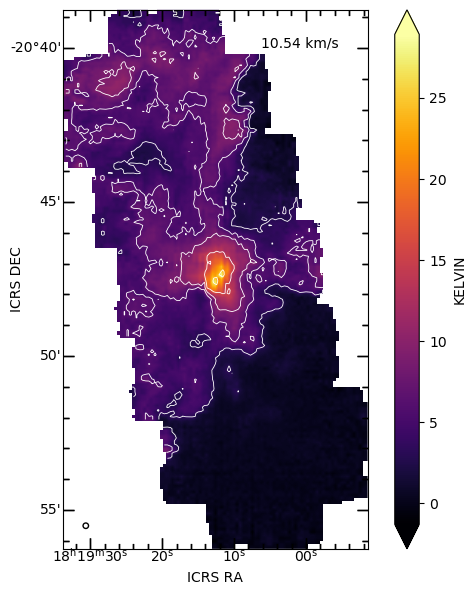

In [5]:
bk = "HH80"
channel = 147
plot_chan_cube(cubes[bk], channel, hdrs[bk],
               box=None,
               plot_cbar=True,
               cmap="inferno",
               interpolation="bilinear",
               render="both",
               contour_levels=np.array([3, 6, 9, 15, 25, 40])*1,
               contour_colors="w",
               contour_linewidths=0.6,
               )

plt.show()

# Define points for PV

In [6]:
# PV_line = {"start": "18h19m20s -20d53m30s",
#            "end": "18h19m10s -20d51m10s"}

# PV_line = {"start": "18h19m28s -20d50m50s",
#              "end": "18h19m20s -20d47m10s"}
#Fuente K
#PV_line = {"start": "18h18m56.953s -20d53m29.458s",
#             "end": "18h19m02.813s -20d55m14.780s"}

#Fuente C
#PV_line = {"start": "18h19m08.148s -20d51m35.858s",
#             "end": "18h19m01.200s -20d53m40.047s"}

#Fuente B
#corte justo en el pico de emsision
PV_line = {"start": "18h19m11.463s -20d50m47.735s",
             "end": "18h19m01.908s -20d50m38.092s"}

#corte arriba del pico de emision (recta color verde en el mapa de momento)
#PV_line = {"start": "18h19m11.463s -20d50m27.735s",
#             "end": "18h19m01.908s -20d50m18.092s"}

#Fuente J
#PV_line = {"start": "18h19m19.6s -20d50m30s",
#             "end": "18h19m13.5s -20d50m58s"}

#Fuente I
#corte en el pico de emision
#PV_line = {"start": "18h19m24.2s -20d47m19s",
#             "end": "18h19m20.005s -20d49m51.406s"}

#corte a la izquierda de los picos de emision (recta color verde en el mapa de momento)
#PV_line = {"start": "18h19m26.2s -20d47m39s",
#             "end": "18h19m22.005s -20d50m11.406s"}

#corte perpendicular (recta color azul en el mapa de momento)
#PV_line = {"start": "18h19m19.7s -20d47m45s",
#             "end": "18h19m27.5s -20d48m55s"}


#Fuente F
#PV_line = {"start": "18h19m12.6s -20d51m45s",
#             "end": "18h19m19.6s -20d54m10s"}


PV_line["width"] = 3

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


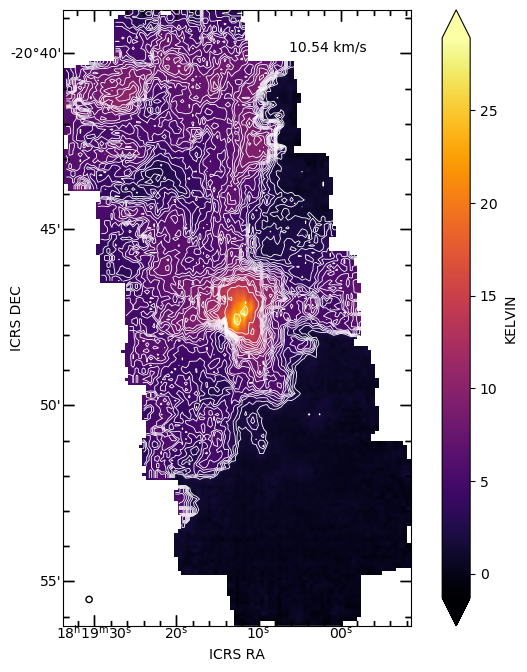

In [7]:
bk = "HH80"

plt.figure(figsize=(8,8))
ax = plt.subplot(projection=wcss[bk])

plot_chan_cube(cubes[bk], channel, hdrs[bk],
               box=None,
               plot_cbar=True,
               cmap="inferno",
               interpolation="bilinear",
               render="both",
               ax=ax,
               contour_levels=np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  25, 40])*0.6,
               contour_colors="w",
               contour_linewidths=0.6,
               )

plt.show()

In [8]:
bk = "HH80"

plt.figure(figsize=(8,8))
ax = plt.subplot(projection=wcss[bk])

plot_chan_cube(cubes[bk], channel, hdrs[bk],
               box=None,
               plot_cbar=True,
               cmap="inferno",
               interpolation="bilinear",
               render="both",
               ax=ax,
               contour_levels=np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  25, 40])*0.6,
               contour_colors="w",
               contour_linewidths=0.6,
               )


PV_line["start_sky"] = SkyCoord(PV_line["start"], frame='icrs')
PV_line["end_sky"] = SkyCoord(PV_line["end"], frame='icrs')

PV_line["start_pixel"] = PV_line["start_sky"].to_pixel(wcss[bk])
PV_line["end_pixel"] = PV_line["end_sky"].to_pixel(wcss[bk])

PV_line['PA'] = \
    PV_line['end_sky'].position_angle(PV_line['start_sky']).deg

PV_line["separation"] = PV_line['end_sky'].separation(PV_line['start_sky'])
PV_line["middle_sky"] = PV_line["end_sky"].directional_offset_by(
    PV_line["PA"]*u.deg,
    PV_line["separation"]/2
)
PV_line["middle_pixel"] = PV_line["middle_sky"].to_pixel(wcss[bk])

# doff = 1.4 
# PV_points["separation"] = PV_points['start_sky'].separation(PV_points['end_sky'])
# PV_points["end_ext"] = LV_IHV_PV_sky['start'].directional_offset_by(PV_points['PA']*u.deg,
#                                                               doff*PV_points["separation"])

ax.plot((PV_line['start_sky'].ra.value, PV_line['end_sky'].ra.value), 
        (PV_line['start_sky'].dec.value, PV_line['end_sky'].dec.value), 
            'c--.',
           linewidth=2,
           transform=ax.get_transform('icrs'))

ax.plot(PV_line['middle_pixel'][0],
        PV_line['middle_pixel'][1],
            'wx', markersize=8, markeredgewidth=2,
           linewidth=2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# PV Diagram

In [9]:
#########################################
# Center to the middle point and rotate #
#########################################

bk = "HH80"

PArot = PV_line["PA"] - 90
rotbk = f"{bk}_rotated{PArot:.0f}" 

reshape = True
cubes[rotbk] = np.zeros(
    (np.shape(cubes[bk])[0],
    np.shape(rotate(cubes[bk][0], angle=PArot, reshape=reshape))[0],
    np.shape(rotate(cubes[bk][0], angle=PArot, reshape=reshape))[1],)
)
for chan in range(np.shape(cubes[bk])[0]):
    ny, nx = np.shape(cubes[bk][chan])
    shift_pixels = [
        int(ny/2-PV_line["middle_pixel"][1]),
        int(nx/2-PV_line["middle_pixel"][0])
    ]
    shift_array = np.roll(
        cubes[bk][chan],
        shift=shift_pixels,
        axis=[0,1])
    cubes[rotbk][chan] = rotate(
        shift_array,
        angle=PArot,
        reshape=reshape,
        order=1)
    
hdrs[rotbk] = hdrs[bk].copy()
wcss[rotbk] = WCS(hdrs[rotbk]).celestial
# beamareas[rotbk] = beamareas[bk]
velchans[rotbk] = vel_from_header(hdrs[bk])
chanwidths[rotbk] = np.abs(velchans[rotbk][1]-velchans[rotbk][2])

ang = - PArot * np.pi/180
ny_rotated, nx_rotated = np.shape(cubes[rotbk][channel])
y_center_rotated, x_center_rotated = ny_rotated / 2, nx_rotated / 2
for p in ["start_pixel", "end_pixel"]:
    length_x = PV_line[p][0]-PV_line["middle_pixel"][0]
    length_y = PV_line[p][1]-PV_line["middle_pixel"][1]
    PV_line[f"{p}_rotated{PArot:.0f}"] =  np.array([
        length_x*np.cos(ang) - length_y*np.sin(ang) + x_center_rotated,
        length_x*np.sin(ang) + length_y*np.cos(ang) + y_center_rotated
    ])
    
#############
# CUTOUT 3D #
#############   

rotbkc = f"{rotbk}_cutout"
chans = [0, len(cubes[rotbk])-1]
sizex = np.abs(int(
    PV_line[f"start_pixel_rotated{PArot:.0f}"][0] 
    - PV_line[f"end_pixel_rotated{PArot:.0f}"][0]))
cubes[rotbkc], hdrs[rotbkc] = cutout3D(
    cubes[rotbk],
    chans=chans,
    position=[x_center_rotated, y_center_rotated],
    header=hdrs[rotbk],
    size=[PV_line["width"], sizex]
)
wcss[rotbkc] = WCS(hdrs[rotbkc]).celestial
velchans[rotbkc] = vel_from_header(hdrs[rotbkc])
chanwidths[rotbkc] = np.abs(velchans[rotbkc][1]-velchans[rotbkc][2])   

######
# PV #
######
    
nv_cutout, ny_cutout, nx_cutout = np.shape(cubes[rotbkc])
pv_diagram = np.mean(cubes[rotbkc], 1)
   

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Plot PV

In [37]:
vel_limits=[6.5, 18.0]
# vel_limits = None

In [42]:
gs = GridSpec(2, 1, 
              height_ratios=[0.1,1],
              width_ratios=[10.5])
wspace = 0.05
hspace = 0.05
gs.update(left=0.05, right=0.95,
          bottom=0.08, top=0.93,
          wspace=wspace, hspace=hspace)

ax = plt.subplot(gs[1, 0])
cbax = plt.subplot(gs[0, 0])


extent =[
    0, np.abs(hdrs["HH80"]["CDELT1"])*3600*nx_cutout,
    velchans[bk][0], velchans[bk][-1]
]



im = ax.imshow(pv_diagram,
          origin="lower",
          aspect="auto",
          extent=extent,
          cmap="plasma",
          interpolation="bilinear",
          vmin=0, 
          vmax=1.5
              )

clev = 0.08
#levs = (-3*clev, 3*clev, 4*clev, 5*clev, 6*clev, 7*clev, 8*clev, 9*clev, 10*clev, 11*clev, 12*clev, 13*clev, 14*clev, 15*clev, 16*clev, 17*clev, 18*clev, 19*clev, 20*clev, 21*clev, 22*clev, 23*clev, 24*clev, 25*clev, 26*clev, 27*clev, 28*clev, 29*clev, 30*clev, 31*clev, 32*clev, 33*clev, 34*clev, 35*clev)
levs = (-3*clev, 3*clev, 5*clev, 7*clev, 9*clev, 11*clev, 13*clev, 15*clev, 17*clev, 19*clev, 21*clev, 23*clev, 25*clev, 27*clev, 29*clev, 31*clev, 33*clev, 35*clev, 40*clev, 45*clev, 50*clev, 55*clev, 60*clev, 65*clev, 70*clev, 75*clev, 80*clev, 85*clev)


im1 = ax.contour(pv_diagram,
                origin="lower",
                aspect="auto",
                extent=extent,
                interpolation="bilinear",
                levels= levs,
                linewidths=0.6,
                colors='black',
                smooth=1.5
                )



plt.colorbar(im, cax=cbax, orientation="horizontal", extend="max")
cbax.tick_params(axis="x", top=True, bottom=False, labelbottom=False,
                 labeltop=True,)
cbax.set_xlabel("Intensidad (K)")
cbax.xaxis.set_label_position("top")
ax.set_aspect("auto")

if vel_limits is not None:
    ax.set_ylim(vel_limits)

ax.set_xlabel("Offset (arcsec)")
ax.set_ylabel("Velocidad (km/s)")


#plt.show()
plt.savefig('pv_plot_outflow_b.png', bbox_inches='tight')

<ipython-input-42-22aa575d8512>:36: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation', 'smooth'
  im1 = ax.contour(pv_diagram,


### Verification

#### Rotated and centered image

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
ax.imshow(cubes[rotbk][channel], origin="lower", cmap="inferno" )
ax.plot((PV_line[f'start_pixel_rotated{PArot:.0f}'][0],  PV_line[f'end_pixel_rotated{PArot:.0f}'][0]), 
        (PV_line[f'start_pixel_rotated{PArot:.0f}'][1],  PV_line[f'end_pixel_rotated{PArot:.0f}'][1]), 
            'c--.',
           linewidth=2,)
ax.plot(x_center_rotated,
        y_center_rotated,
            'wx', markersize=8, markeredgewidth=2,
           linewidth=2)

#### Data to collapse in Y axis

In [ ]:
plt.imshow(cubes[rotbkc][channel], origin="lower", cmap="inferno" )